In [2]:
import julia
jl = julia.Julia(compiled_modules=False)
from julia import Main
import numpy as  np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import csv
import pandas as pd
from naive_agents import DoNothing, FixedPhi
from actor_physicists_abc import RL_phi_agent
from abc_env import ABC_env

In [3]:
# PARAMS
A = 1.
B = 0.7
C = 0.43
NU = 0.99
kappa = 0.001
BETA = 0.1
baseline_phi = 0.4
D = 0.1 # placeholder for now
dims = 3

In [4]:
trained = RL_phi_agent(dims,action_scale=5.)
trained.load_policy(f"saved_models/abc_env_{1.6}_10.0.pt")
fixed = FixedPhi(1.6)
#agents = [FixedPhi(1.1),trained]
#identifiers = ["fixed_1.1","trained_1.1_ep=500"]


In [5]:
env = ABC_env(A,B,C,0.2*np.pi,BETA,kappa,D,NU)
dummy_env = ABC_env(A,B,C,0.2*np.pi,BETA,kappa,D,NU)
env.deltaT=dummy_env.deltaT=0.05

┌ Warning: Replacing docs for `SciMLBase.sol :: Union{Tuple, Tuple{D}, Tuple{S}, Tuple{N}, Tuple{T}} where {T, N, S, D}` in module `SciMLBase`
└ @ Base.Docs docs/Docs.jl:240


In [11]:
# Hackey visualization to see a fixed agent and an RL agent


interesting_eps = False


while not interesting_eps:

    rl_active=[]
    fixed_active=[]
    passive=[]
    rl_rewards=[]
    fixed_rewards=[]
    env.reset()
    dummy_env.reset()
    dummy_env.active = env.active
    RL_cum_rew=0
    fixed_cum_rew=0
    
    
    while not env.isOver():
        dummy_env.passive=env.passive
        rl_active.append(env.active)
        passive.append(env.passive)
        rl_rewards.append(RL_cum_rew)
        fixed_rewards.append(fixed_cum_rew)
        fixed_active.append(dummy_env.active)
        rl_action = trained.sample_action(env.getState())
        fixed_action = fixed.sample_action(dummy_env.getState())
        RL_cum_rew += env.step(rl_action)
        fixed_cum_rew += dummy_env.step(fixed_action)
        
    print(RL_cum_rew-fixed_cum_rew)
    if RL_cum_rew < -2.:
        interesting_eps = True

        
rl_active=np.array(rl_active)
passive=np.array(passive)
fixed_active=np.array(fixed_active)





0.1426182160293198
0.13266208899254087
0.14507068932528702
0.10579191813759647
0.0765815707305228
0.17478408331259557
0.06627857502296203
0.03657832953553031
0.15701721284223172
0.07400991760523723
0.161036506857995
0.07320865906538271
0.17908806200020905
0.12768070931250963
0.12467447073953361
0.12258616672603645
0.06146792554679864
-0.07965694493785691
0.17966030772182434
0.09273430950636385
0.1242269712476941
0.10593622176356998
0.12940373958801962
0.1336566088289372
0.1465614664407271
0.1346896405466083
0.18585562809436396
0.07933621513362052
0.03204360673047546
0.15309239833237187
0.12279155218387147
0.07294535452166812
0.13695965717508438
0.14675944732857854
0.09024563991204088
0.09843102337653695
0.1365721914713349
0.11141916427898413
0.21101153284725568
0.15279118850187762
0.11076342082789967
0.12421158754352479
0.11257182596804693
0.12859869204635968
0.032960588167635085
0.1583386592312583
0.20324398888892986
0.1385999323002053
0.1056509925587546
0.18131018856124378
-0.0551893

In [7]:
# save data to a csv
data = {"rl_traj":rl_active,
        "fixed_traj":fixed_active,
        "passive_traj":passive,
        "rl_rewards":rl_rewards,
        "fixed_rewards":fixed_rewards}
name = "slow_convergence"
with open(f"{name}.csv","w") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(data.keys())
    writer.writerows(zip(*data.values()))

/tmp/ipykernel_4332/1947840866.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0.,color_norm), cmap='jet'), label='Penalty')


Text(0, 0.5, 'separation size')

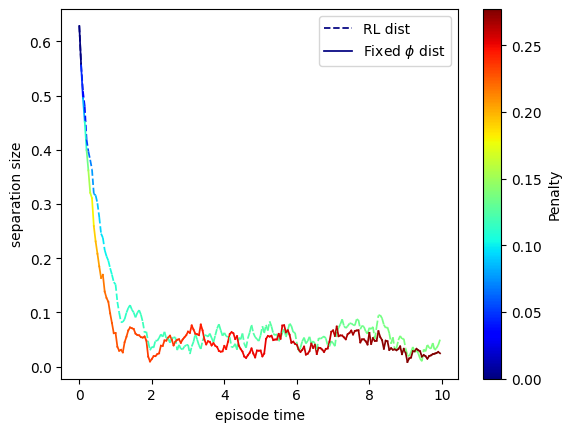

In [9]:
rl_sep = data["passive_traj"]-data["rl_traj"]
rl_sep = np.sum(np.abs(rl_sep)**2,axis=-1)**(1./2)
fixed_sep = data["passive_traj"] - data["fixed_traj"]
fixed_sep = np.sum(np.abs(fixed_sep)**2,axis=-1)**(1./2)
time_arr = np.arange(len(rl_sep))*env.deltaT
color_norm= - min(min(data["rl_rewards"]),min(data["fixed_rewards"]))


#plt.plot(time_arr,rl_sep)
#plt.plot(time_arr,fixed_sep)
# plot line segments with color based on associated value
for i in range(len(time_arr) - 1):
    #print(plt.cm.jet(rl_rewards[i]/color_norm))
    plt.plot(time_arr[i:i+2], rl_sep[i:i+2], "--",color=plt.cm.jet(-data["rl_rewards"][i]/color_norm), linewidth=1.25) 
    plt.plot(time_arr[i:i+2], fixed_sep[i:i+2], color=plt.cm.jet(-data['fixed_rewards'][i]/color_norm), linewidth=1.25)

    
plt.legend(labels=["RL dist","Fixed $\phi$ dist"])

     
    
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0.,color_norm), cmap='jet'), label='Penalty')

plt.xlabel("episode time")
plt.ylabel("separation size")

/tmp/ipykernel_4332/1418345214.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0.,color_norm), cmap='jet'), label='Penalty')


Text(0, 0.5, 'separation size')

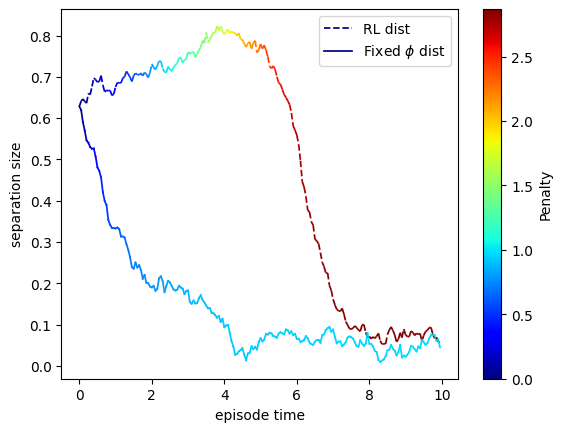

In [13]:
rl_sep = passive-rl_active
rl_sep = np.sum(np.abs(rl_sep)**2,axis=-1)**(1./2)
fixed_sep = passive - fixed_active
fixed_sep = np.sum(np.abs(fixed_sep)**2,axis=-1)**(1./2)
time_arr = np.arange(len(rl_sep))*env.deltaT
color_norm= - min(min(rl_rewards),min(fixed_rewards))


#plt.plot(time_arr,rl_sep)
#plt.plot(time_arr,fixed_sep)
# plot line segments with color based on associated value
for i in range(len(time_arr) - 1):
    #print(plt.cm.jet(rl_rewards[i]/color_norm))
    plt.plot(time_arr[i:i+2], rl_sep[i:i+2], "--",color=plt.cm.jet(-rl_rewards[i]/color_norm), linewidth=1.25) 
    plt.plot(time_arr[i:i+2], fixed_sep[i:i+2], color=plt.cm.jet(-fixed_rewards[i]/color_norm), linewidth=1.25)

    
plt.legend(labels=["RL dist","Fixed $\phi$ dist"])

     
    
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0.,color_norm), cmap='jet'), label='Penalty')

plt.xlabel("episode time")
plt.ylabel("separation size")

In [1]:

fig = go.Figure(data=go.Scatter3d(
        x=passive[:,0],
        y=passive[:,1],
        z=passive[:,2],
        mode='lines',
        name = "passive trajectory"
      )
    )

fig.add_trace(go.Scatter3d(
    x=rl_active[:,0],
    y=rl_active[:,1],
    z=rl_active[:,2],
    mode='lines',
    name="RL agent"
))


fig.add_trace(go.Scatter3d(
    x=fixed_active[:,0],
    y=fixed_active[:,1],
    z=fixed_active[:,2],
    mode='lines',
    name="Fixed phi"
))

NameError: name 'go' is not defined

Text(0, 0.5, 'separation size')

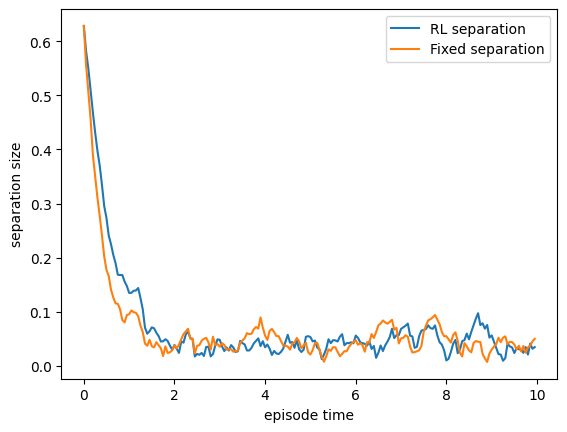

In [50]:
rl_sep = passive-rl_active
rl_sep = np.sum(np.abs(rl_sep)**2,axis=-1)**(1./2)
fixed_sep = passive - fixed_active
fixed_sep = np.sum(np.abs(fixed_sep)**2,axis=-1)**(1./2)
plt.plot(np.arange(len(rl_sep))*env.deltaT,rl_sep)
plt.plot(np.arange(len(rl_sep))*env.deltaT,fixed_sep)
plt.legend(labels=["RL separation","Fixed separation"])
plt.xlabel("episode time")
plt.ylabel("separation size")

In [49]:
fig = go.Figure(data=go.Scatter3d(
        x=passive[:,0],
        y=passive[:,1],
        z=passive[:,2],
        mode='lines',
        name = "passive trajectory"
      )
    )

fig.add_trace(go.Scatter3d(
    x=rl_active[:,0],
    y=rl_active[:,1],
    z=rl_active[:,2],
    mode='lines',
    name="RL agent"
))


fig.add_trace(go.Scatter3d(
    x=fixed_active[:,0],
    y=fixed_active[:,1],
    z=fixed_active[:,2],
    mode='lines',
    name="Fixed phi"
))

In [87]:
fig.write_html("visualization_expiermentation2.html")

In [7]:
active

[array([ 2.83188394, -0.6893584 , -0.87114792]),
 array([ 2.77785481, -0.62952878, -0.93110279]),
 array([ 2.72618261, -0.57676576, -1.00133599]),
 array([ 2.66547452, -0.5298668 , -1.07084884]),
 array([ 2.61526162, -0.45711802, -1.13436309]),
 array([ 2.5671579 , -0.40969348, -1.19342628]),
 array([ 2.50278538, -0.35259012, -1.2605479 ]),
 array([ 2.45353911, -0.29464141, -1.3059512 ]),
 array([ 2.38971774, -0.22684482, -1.35193673]),
 array([ 2.31696591, -0.16111318, -1.38324002]),
 array([ 2.24854919, -0.09068202, -1.43372119]),
 array([ 2.19802309, -0.04356002, -1.46075528]),
 array([ 2.15466325,  0.03560308, -1.47527678]),
 array([ 2.10217399,  0.10031732, -1.50600806]),
 array([ 2.04638251,  0.1444942 , -1.5392129 ]),
 array([ 1.97672463,  0.21115199, -1.56186514]),
 array([ 1.91977691,  0.23301618, -1.57773205]),
 array([ 1.86412785,  0.2894561 , -1.6159136 ]),
 array([ 1.81278266,  0.34413391, -1.60638042]),
 array([ 1.75656614,  0.40330798, -1.61053482]),
 array([ 1.69789236,